In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork:
    def __init__(
        self,
        input_size,
        hidden_sizes=[4],  # List of hidden layer sizes (e.g., [4, 4] for 2 hidden layers)
        output_size=2,
        activation="relu",  # "sigmoid" or "relu"
        regularization="l2",  # "l2" or None
        lambda_reg=0.01,     # L2 regularization strength
        dropout_rate=0.0,     # Dropout rate (0.0 to disable)
        optimizer="adam",     # "gd" (gradient descent) or "adam"
    ):
        # Initialize architecture
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.activation = activation
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer

        # weights and biases
        self.weights = []
        self.biases = []
        for i in range(len(self.layer_sizes) - 1):
            self.weights.append(
                np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * 0.01
            )
            self.biases.append(np.zeros((1, self.layer_sizes[i+1])))

        # Adam
        if self.optimizer == "adam":
            self.m = [np.zeros_like(w) for w in self.weights]  # First moment
            self.v = [np.zeros_like(w) for w in self.weights]  # Second moment
            self.t = 1  # Time step
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X, training=True):
        self.activations = [X]
        self.z_layers = []
        self.dropout_masks = []

        # Forward pass
        for i in range(len(self.weights)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_layers.append(z)

            if i == len(self.weights) - 1:
                # softmax
                activation = self.softmax(z)
            else:
                # ReLU 
                if self.activation == "relu":
                    activation = self.relu(z)
                else:
                    activation = self.sigmoid(z)

                # Apply dropout during training
                if training and self.dropout_rate > 0:
                    mask = (np.random.rand(*activation.shape) > self.dropout_rate).astype(float)
                    mask /= (1 - self.dropout_rate)  # Inverted dropout 1/(1 - dropout_rate)
                    self.dropout_masks.append(mask)
                    activation *= mask

            self.activations.append(activation)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        cross_entropy = -np.sum(y_true * np.log(y_pred + 1e-8)) / m

        # L2
        if self.regularization == "l2":
            l2_penalty = 0
            for w in self.weights:
                l2_penalty += 0.5 * self.lambda_reg * np.sum(w ** 2)# loss+= (lambda_reg / 2m) * sum(weights^2)
            cross_entropy += l2_penalty / m

        return cross_entropy

    def backward(self, X, y_true, y_pred, learning_rate):
        m = y_true.shape[0]
        gradients = []

        # Output layer gradient
        dz = y_pred - y_true
        for i in reversed(range(len(self.weights))):
            if i == len(self.weights) - 1:
                # Output layer
                dw = np.dot(self.activations[i].T, dz) / m
                db = np.sum(dz, axis=0, keepdims=True) / m
            else:
                # Hidden layers
                if self.activation == "relu":
                    da = self.relu_derivative(self.z_layers[i])
                else:
                    da = self.sigmoid_derivative(self.z_layers[i])

                
                if self.dropout_rate > 0 and i < len(self.dropout_masks):
                    da *= self.dropout_masks[i]

                dz = np.dot(dz, self.weights[i+1].T) * da
                dw = np.dot(self.activations[i].T, dz) / m
                db = np.sum(dz, axis=0, keepdims=True) / m

            # L2 regularization gradient
            if self.regularization == "l2":
                dw += (self.lambda_reg / m) * self.weights[i]

            gradients.append((dw, db))

        # Reverse gradients
        gradients = gradients[::-1]

        # Update weights @ Adam
        for i in range(len(self.weights)):
            dw, db = gradients[i]
            if self.optimizer == "adam":
                # Adam update
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * dw 
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (dw ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                update = learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)  #w = w - learning_rate * m_hat / (sqrt(v_hat) + epsilon)
                self.weights[i] -= update
                self.biases[i] -= learning_rate * db
            else:
                # gradient descent
                self.weights[i] -= learning_rate * dw
                self.biases[i] -= learning_rate * db

        if self.optimizer == "adam":
            self.t += 1

    def train(self, X, y, epochs=1000, learning_rate=0.1):
        losses = []
        for epoch in range(epochs):
            # Forward 
            y_pred = self.forward(X, training=True)
            loss = self.compute_loss(y, y_pred)
            losses.append(loss)

            # Backward
            self.backward(X, y, y_pred, learning_rate)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

        #training loss
        plt.plot(losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()

    def predict(self, X):
        return np.argmax(self.forward(X, training=False), axis=1)
            
    

In [3]:
X = np.array([[0,0], [0,1],[1,0],[1,1]])
y = np.array([[1,0], [0,1],[0,1],[1,0]])

Epoch 0, Loss: 0.6931512198748739
Epoch 100, Loss: 0.6931470519449247
Epoch 200, Loss: 0.6931472624695658
Epoch 300, Loss: 0.6931473439773125
Epoch 400, Loss: 0.6931470952686689
Epoch 500, Loss: 0.693148659046298
Epoch 600, Loss: 0.6931966504944383
Epoch 700, Loss: 0.7152956345267363
Epoch 800, Loss: 0.5632052902582834
Epoch 900, Loss: 0.71804753447714


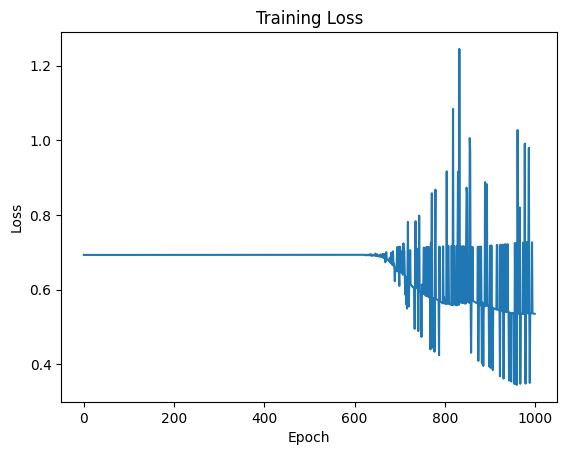

Predictions: [0 1 1 1]


In [5]:
nn = NeuralNetwork(
    input_size=2,
    hidden_sizes=[4, 4],  # Two hidden layers
    activation="relu",
    regularization="l2",
    lambda_reg=0.01,
    dropout_rate=0.2,
    optimizer="adam"
)

nn.train(X, y, epochs=1000, learning_rate=0.01)


predictions = nn.predict(X)
print("Predictions:", predictions)